In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction
**Autoencoders** are neural network architectures used for unsupervised learning tasks. They are designed to learn efficient representations of input data by compressing it into a lower-dimensional latent space and then reconstructing it back to its original form. Autoencoders consist of two main components: an encoder and a decoder.
 - The encoder takes in the input data and maps it to a lower-dimensional latent representation. It typically consists of multiple layers that gradually reduce the dimensionality of the input data, capturing its essential features. The output of the encoder is a compressed representation of the input, often referred to as a code or latent vector.
 - The decoder, on the other hand, takes the code from the encoder and reconstructs the original data from it. It mirrors the architecture of the encoder by gradually expanding the code back to the original dimensionality. The output of the decoder is a reconstruction of the input data, which ideally should closely resemble the original input.

**Variational Autoencoders** are a more powerful class of generative models. They combine elements from both autoencoders and probabilistic models to learn an efficient representation of high-dimensional data. VAEs are designed to capture the underlying latent variables that drive the generation of the observed data, enabling them to generate new samples from the learned distribution. Unlike traditional autoencoders, VAEs introduce a **probabilistic component** that allows them to model the data distribution more effectively.

Autoencoders have various applications, including dimensionality reduction, data denoising, and anomaly detection. They can learn useful representations from unlabeled data, which can then be used for downstream tasks like classification or clustering. In this assignemnt we will be exploring the **generative capabilities** of autoencoders and VAE's. By exploring the latent space, we can generate novel samples, allowing for creative applications such as image synthesis or style transfer.

In [3]:
# IMPORT LIBRARIES
import tensorflow.keras as keras
import pandas as pd
import tensorflow as tf
import numpy as np
import PIL
import PIL.Image
import sklearn
import scipy
import pathlib
import time
import os
import matplotlib.pyplot as plt

In [4]:
#Ensure that you have access to Colab's GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()

Num GPUs Available:  1


# Part 0: Get the data

The dataset is quite large (>200 k high res. images), however it can be accessed through TensorFlow Datasets. Please note that there is a limit on how many request you can ask within 24h. If you get HTTP error 429 it means you have exceeded that limit. Please concider this when working on the task - aka do as much as posible each session (also try to avoid restarting the kernel).

(The data can also be downloaded directly from the authers [here](https://drive.google.com/drive/folders/1E34_MII_Gw4cAy0lS6BfN62a7ut9Af_2?usp=share_link) )

In [ ]:
import tensorflow_datasets as tfds
celeba_bldr = tfds.builder('celeb_a')
celeba_bldr.download_and_prepare()
celeba = celeba_bldr.as_dataset(shuffle_files=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

DownloadError: ignored

*If you havig trouble downloading the data (ERROR 429) you can extract the .zip file from the link above*
1. *Copy the -zip folders to your drive (see link above)*
2. *Unzip folder (You can chose between unzipping in the noteboke, or your drive)*

```
!unzip -u "/YOUR_DRIVE_PATH/celeba_train.zip" -d "/YOUR_DESTINATION_PATH/train"
```
3. *Extract the dataset (ps. train heter test i undermappene)*


```
celeba_train = tf.dataDataset.load('/YOUR_DESTINATION_PATH/train/content/CelebA_test'
```
4. *Repeat for test*


In [ ]:
!unzip -u "/content/drive/MyDrive/celeba_train.zip" -d "/content/drive/MyDrive/train."

Archive:  /content/drive/MyDrive/celeba_train.zip
   creating: /content/drive/MyDrive/train./content/CelebA_test/
  inflating: /content/drive/MyDrive/train./content/CelebA_test/dataset_spec.pb  
  inflating: /content/drive/MyDrive/train./content/CelebA_test/snapshot.metadata  
   creating: /content/drive/MyDrive/train./content/CelebA_test/4748077372869299807/
   creating: /content/drive/MyDrive/train./content/CelebA_test/4748077372869299807/00000000.shard/
  inflating: /content/drive/MyDrive/train./content/CelebA_test/4748077372869299807/00000000.shard/00000000.snapshot  


In [ ]:
!unzip -u "/content/drive/MyDrive/celeba_validation.zip" -d "/content/drive/MyDrive/validation."


Archive:  /content/drive/MyDrive/celeba_validation.zip
   creating: /content/drive/MyDrive/validation./content/CelebA_validation/
   creating: /content/drive/MyDrive/validation./content/CelebA_validation/13188610466669287276/
   creating: /content/drive/MyDrive/validation./content/CelebA_validation/13188610466669287276/00000000.shard/
  inflating: /content/drive/MyDrive/validation./content/CelebA_validation/13188610466669287276/00000000.shard/00000000.snapshot  
  inflating: /content/drive/MyDrive/validation./content/CelebA_validation/dataset_spec.pb  
  inflating: /content/drive/MyDrive/validation./content/CelebA_validation/snapshot.metadata  


In [5]:
celeba_train_path = '/content/drive/MyDrive/train./content/CelebA_test'
celeba_validation_path = '/content/drive/MyDrive/validation./content/CelebA_validation'

celeba_train = tf.data.Dataset.load(celeba_train_path)
celeba_validation = tf.data.Dataset.load(celeba_validation_path)


In [6]:
# Checking both datasets structure
for data in celeba_train.take(1):
    print(data.keys())


    attributes = data['attributes']
    images = data['image']
    landmarks = data['landmarks']


for data in celeba_validation.take(1):
    print(data.keys())


    attributes = data['attributes']
    images = data['image']
    landmarks = data['landmarks']







dict_keys(['identity', 'landmarks', 'image', 'attributes'])
dict_keys(['attributes', 'landmarks', 'image', 'identity'])




---



# Part 1: Build an Autoencoder network

<div>
<img src="https://tikz.net/janosh/autoencoder.png" width="400"/>
<div>

## Task 1.1 Define a prerocessing function

- The images are orignial 218x178, however it could be usefull to reduce the size for efficency purposes.
- As always: preprocessing the image increase performance
- As we are only concerd with reconstruction loss (e.g. try to reconstruct the same image) **we do not care about labels**
- For this reason, a test set is not always needed, altough it will be usefull to have a small "test set" available for emperical experiments.


Following is an example on how to design a keras preprocessing function.
```
def preprocess(example, size=(img_h, img_w), mode='train'):
    image = example['image']
    if mode == 'train':
        image_resized = tf.image.resize(image, size=size)
        return image_resized/255.0, image_resized/255.0
```



In [7]:
BATCH_SIZE = 32
img_w, img_h = 64,64

In [8]:
def preprocess(example, size=(img_w, img_h), mode='train'):
  image = example['image']
  if mode == 'train':
    image_resized = tf.image.resize(image, size=size)

    return image_resized/255.0, image_resized/255.0


In [9]:
train_ds = celeba_train.map(lambda x: preprocess(x))
train_ds = train_ds.batch(BATCH_SIZE)

validation_ds = celeba_validation.map(lambda x: preprocess(x))
validation_ds = validation_ds.batch(BATCH_SIZE)

## Task 1.2 Visualize the dataset

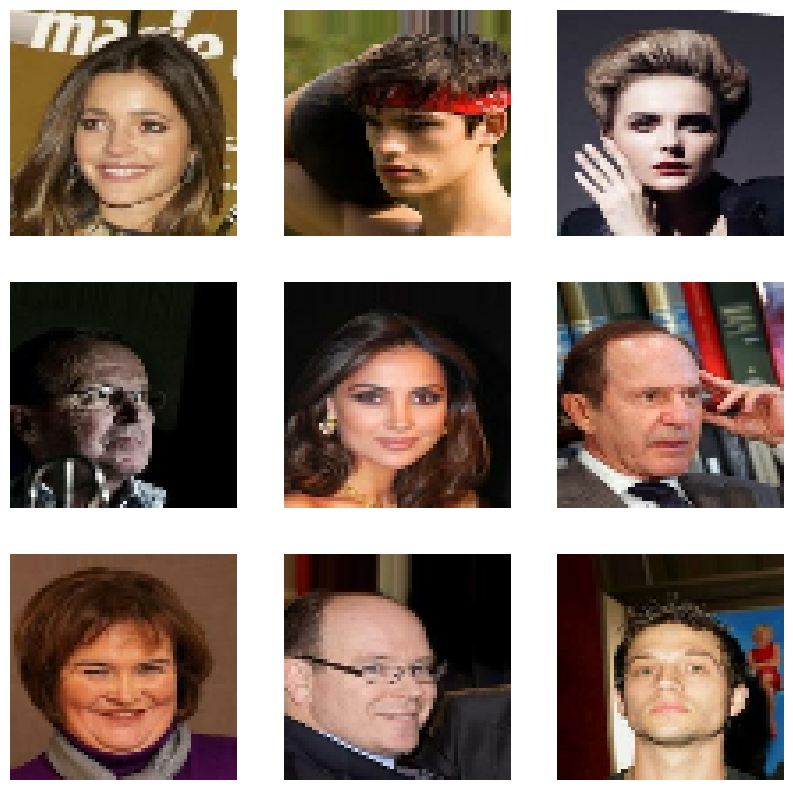

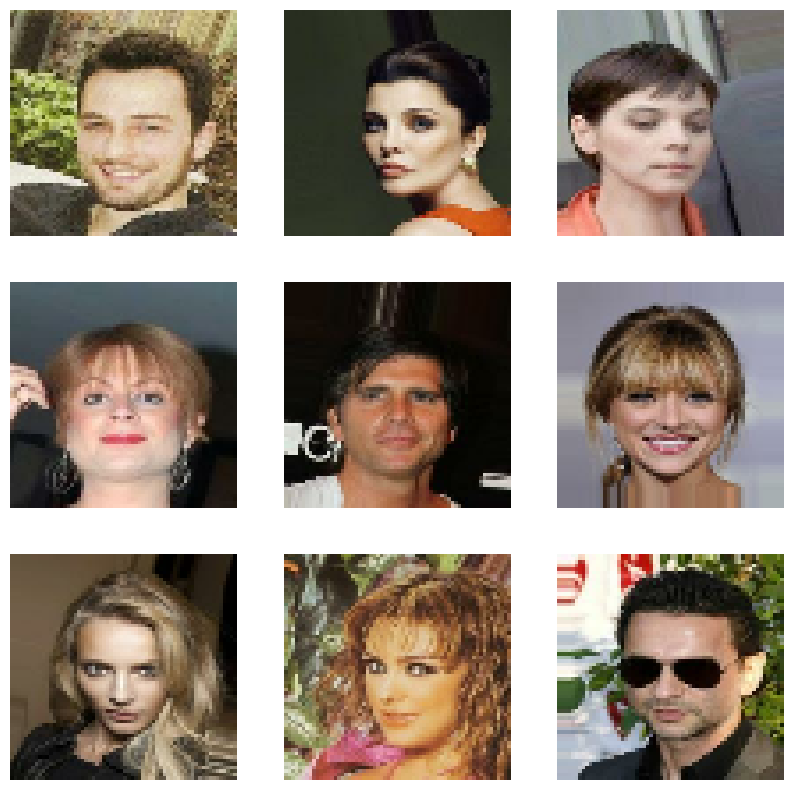

In [10]:
# Visualize a few images from the datasets
def show_batch(dataset, num_images=9):

    plt.figure(figsize=(10, 10))

    for images, _ in dataset.take(1):
        for i in range(num_images):

            ax = plt.subplot(3, 3, i + 1)

            plt.imshow(images[i].numpy())
            plt.axis("off")


show_batch(train_ds)
show_batch(validation_ds)




## Task 1.3 Build a linear encoder and decoder

- The images needs to be flattent before feed into the input layer.
- The output from the decoder needs to be reshaped back into an three-channel image.
- Ensure the output from the decoder are in the valid pixel range (0-1).
- Train the network in at least five epochs

`laten_dim = 64`

1. **Input Layer:**
   - The input layer of the autoencoder takes the raw input data. The size of this layer depends on the dimensionality of the input data. Since we are working with images and dense layers we need to flatten the input space before we can encode it.
   
```
tf.keras.Input(shape=(H,W,C), name='Image input')
tf.keras.layers.Flatten(name='Image_as_vector')
```
2. **Encoder:**
   - The encoder part of the network is responsible for reducing the dimensionality of the input data. It is usually achived by decreasing neuron count.

```
tf.keras.layers.Dense(*args, name='Encode')
```

3. **Latent Space:**
   - The output layer of the encoder is called the latent space. This layer contains the compressed representation of the input
4. **Decoder:**
   - The decoder part of the network aims to reconstruct the original data from the compressed representation in the latent space. It consists layer(s) with an increasing number of neurons

```
tf.keras.layers.Dense(*args, name='Decoder')
#output pixel between 0,1
```
5. **Output Layer:**
   - The output layer of the autoencoder reconstructs the data in a format that matches the input data's dimensionality.

```
tf.keras.layers.Reshape(*args, name='Output')
```


The training process involves minimizing a loss function, typically an **reconstruction loss** which measures the difference between the original input and the reconstructed output. Use Binary cross-entropy loss which emphasizes correct representation of the data. It penalizes the model more when it produces a significantly different value from the ground truth, effectively encouraging the model to capture and reconstruct the important binary features (pixel) accurately.

In [11]:
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam


def build_autoencoder(input_shape, latent_dim):


    input_img = Input(shape=input_shape, name='Image_input')

    flat_img = Flatten(name='Image_as_vector')(input_img)

    encoded = Dense(latent_dim, activation='relu', name='Encode')(flat_img)

    decoded = Dense(input_shape[0] * input_shape[1] * input_shape[2], activation='sigmoid', name='Decoder')(encoded)

    output_img = Reshape(input_shape, name='Output')(decoded)

    autoencoder = Model(input_img, output_img)

    return autoencoder


input_shape = (64, 64, 3)
latent_dim = 64
autoencoder = build_autoencoder(input_shape, latent_dim)




### Task 1.3.1 Train the network and save a reconstructed image at the end of each epoch
- Save chekpoints at end of each training epoch (>5) to visualise the evolution of the reconstructed images during training
- Use ```callbacks=[model_checkpoint_callback]```
 to save weigths at end of each epoche.
- ```optimizer='adam'```
- ```loss='binary_crossentropy'```

```
# Example on how to implement callbacks during training
with tf.device(device_name):
    model.fit(**args, callbacks=[model_checkpoint_callback])
```



In [12]:
# Use this definition of checkpoints
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./tmp/weights_{epoch:02d}.hdf5',
    save_weights_only=True,
    monitor='loss',
    mode='auto',
    save_freq = 'epoch',
    save_best_only=False)


In [13]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

autoencoder.compile(optimizer=optimizer,
                    loss='binary_crossentropy')


autoencoder.fit(train_ds,
                epochs=5,
                validation_data=validation_ds,
                 callbacks=[model_checkpoint_callback])


Epoch 1/5
624/624 [==============================] - 67s 95ms/step - loss: 0.5653 - val_loss: 0.5511
Epoch 2/5
624/624 [==============================] - 29s 46ms/step - loss: 0.5436 - val_loss: 0.5466
Epoch 3/5
624/624 [==============================] - 30s 48ms/step - loss: 0.5404 - val_loss: 0.5439
Epoch 4/5
624/624 [==============================] - 30s 48ms/step - loss: 0.5390 - val_loss: 0.5427
Epoch 5/5
624/624 [==============================] - 28s 45ms/step - loss: 0.5379 - val_loss: 0.5417


### Task 1.3.2 Visualise the reconstruted images during training

Keras ModelCheckpoint is used to save the models (weights) at some frequency. By loading the weights at the end of each epoch we can visualise the output. See example below for how to implement the saved weights from 'filepath'.

```
random_img = np.random.randint(0, len(test_np))
len_check = len(os.listdir('./tmp/'))
fig, ax = plt.subplots(1, len_check+1, figsize=(15,15))
for i, weights in enumerate(os.listdir('./tmp/')[::-1],1):
    epoch_model = tf.keras.models.clone_model()         # Clone the orignal model structure
    epoch_model.load_weights('./tmp/' + weights)
    epoch_pred = epoch_model.predict(test_np, verbose=0)
    ax[0].imshow(test_np[random_img])
    ax[i].imshow(epoch_pred[random_img])
    ax[i].axis('off')
    ax[0].axis('off')
    if i!=len_check:
        ax[i].set_title('Epoch: {}'.format(i))
    else:
        ax[i].set_title('Output')
    ax[0].set_title('Original')```



In [14]:
# Create a numpy array for my validation images
validation_images = []

for images, _ in validation_ds:
    validation_images.append(images.numpy())

validation_np = np.concatenate(validation_images, axis=0)


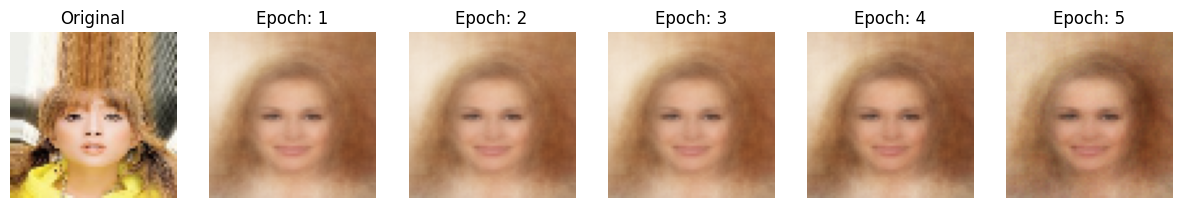

In [16]:

random_img = np.random.randint(0, len(validation_np))
len_check = len(os.listdir('./tmp/'))

fig, ax = plt.subplots(1, len_check + 1, figsize=(15, 15))

# Display the original image
ax[0].imshow(validation_np[random_img])
ax[0].axis('off')
ax[0].set_title('Original')

# Load weights and display reconstructed images
for i, weights in enumerate(sorted(os.listdir('./tmp/'), reverse=True), 1):
    epoch_model = tf.keras.models.clone_model(autoencoder)
    epoch_model.load_weights('./tmp/' + weights)

    # Ensure the image is correctly shaped for prediction
    img_to_predict = validation_np[random_img].reshape(1, *validation_np[random_img].shape)
    epoch_pred = epoch_model.predict(img_to_predict, verbose=0)

    ax[i].imshow(np.clip(epoch_pred[0], 0, 1))
    ax[i].axis('off')
    ax[i].set_title('Epoch: {}'.format(i))



### Task 1.3.3. Discuss:
**The image's resemblance to the origninal is quite good after the first epoch, what might be some reasons for this?**

The initial weights of the model, before training, might have been set in a way that they were already somewhat effective at reconstructing the input data. That gives us a great resemblance after just one epoch, and then its takes more time to see change in the pictures.

## Task 1.4: Train the network using different latent dimensions.
The purpose of latent dimensions in autoencoders is to represent a compressed and continuous encoding space that might;
 1. captures meaningful features and variations within the data
 2. enabling generation of new, similar samples
 3. aiding in tasks like denoising and anomaly detection.


To visually understand the effect of the lantet space, train your network with three differnet dimensions of the latent space (small < 16, medium < 128, and large > 256) and visualise the reconstructed images.




```
latent_dimensions = []         # Example [8,64,128]
model_list        = []         # Empty list to store weights of each latent- dim model
train_history     = []         # Useful for next task
train_time        = []         # Useful for next task

for i in latent_dimensions:
    # Initiate and compile the model
    print('Training model with latent dimension: %d'%(i))
    
    temp_model = model_def(i)
    temp_mode.compile(**args)
    
    start = time.time()
    with tf.device(device_name):
        history = temp_model.fit(*args)
    end = time.time()

    # Store output    
    model_list.append(temp_model.get_weights())
    train_history.append(history)
    train_time.append(end-start)
```



In [18]:

input_shape       = (64, 64, 3)
latent_dimensions = [8,64,128]

model_list        = []
train_history     = []
train_time        = []

for latent_dim in latent_dimensions:
    print(f"Training model with latent dimension: {latent_dim}")


    autoencoder = build_autoencoder(input_shape, latent_dim)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')


    start_time = time.time()
    history = autoencoder.fit(train_ds, epochs=5, validation_data=validation_ds)
    end_time = time.time()


    model_list.append(autoencoder)
    train_history.append(history.history)
    train_time.append(end_time - start_time)




Training model with latent dimension: 8
Epoch 1/5
624/624 [==============================] - 56s 87ms/step - loss: 0.5895 - val_loss: 0.5825
Epoch 2/5
624/624 [==============================] - 50s 80ms/step - loss: 0.5775 - val_loss: 0.5798
Epoch 3/5
624/624 [==============================] - 50s 80ms/step - loss: 0.5755 - val_loss: 0.5785
Epoch 4/5
624/624 [==============================] - 47s 75ms/step - loss: 0.5742 - val_loss: 0.5779
Epoch 5/5
624/624 [==============================] - 47s 75ms/step - loss: 0.5732 - val_loss: 0.5767
Training model with latent dimension: 64
Epoch 1/5
624/624 [==============================] - 48s 75ms/step - loss: 0.5658 - val_loss: 0.5521
Epoch 2/5
624/624 [==============================] - 48s 76ms/step - loss: 0.5463 - val_loss: 0.5493
Epoch 3/5
624/624 [==============================] - 49s 78ms/step - loss: 0.5442 - val_loss: 0.5480
Epoch 4/5
624/624 [==============================] - 49s 78ms/step - loss: 0.5428 - val_loss: 0.5465
Epoch 5/5




```
random_image = np.random.randint(0,len(test_np))
PSNR_list = []                      # Useful for next task

fig, axs = plt.subplots(1, len(latent_dimensions)+1)
axs[0].imshow(test_np[random_image])
axs[0].set_title('Original')

for i in range(len(latent_dimensions)):
    model =                         # Set the orignal model
    model.set_weights(model_list[i])
    reconstructed_image = model.predict(test_np)

    axs[i+1].imshow(reconstructed_image[random_image])
    axs[i+1].set_title('Latent dim: %d'%(latent_dimensions[i]))
    axs[i].axis('off')
    axs[i+1].axis('off')

    PSNR_list.append(np.mean(tf.image.psnr(x_pred, test_np, max_val=1)))
```



1/1 [==============================] - 0s 25ms/step


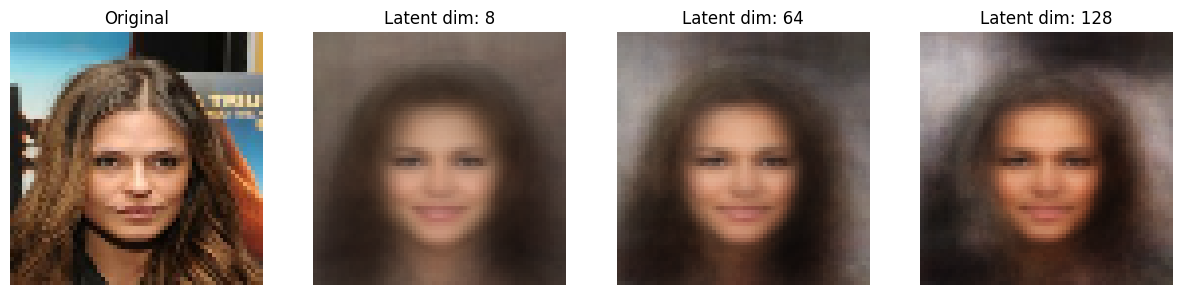

In [20]:
random_image = np.random.randint(0 , len(validation_np))
PSNR_list = []

fig, axs = plt.subplots(1, len(latent_dimensions)+1, figsize=(15,5))
axs[0].imshow(validation_np[random_image])
axs[0].set_title('Original')
axs[0].axis('off')


for i, latent_dim in enumerate(latent_dimensions):
    model = model_list[i]

    # Reconstruct the image
    x_pred = model.predict(validation_np[random_image].reshape(1, *validation_np[random_image].shape))

    # Display the reconstructed image
    axs[i + 1].imshow(x_pred[0])
    axs[i + 1].set_title(f'Latent dim: {latent_dim}')
    axs[i].axis('off')
    axs[i + 1].axis('off')

    # Calculate and append the PSNR value
    PSNR_list.append(tf.image.psnr(x_pred[0], validation_np[random_image], max_val=1.0).numpy())

plt.show()

## Task 1.3.3: What effect does the latent space have on the reconstructed image?

- Here we will compare loss, PSNR value, and training time

PSNR stands for Peak Signal-to-Noise Ratio, and it is a metric commonly used to evaluate the quality of image compression. It measures the ratio between the maximum possible power of a signal (in this case, an image) and the power of the noise introduced by the compression process. Higher values are better.



```
X_axis = np.arange(len(latent_dimensions))
psnr = PSNR_list
train_loss = [train_history[i].history['loss'][0] for i in range(len(train_history))]
```



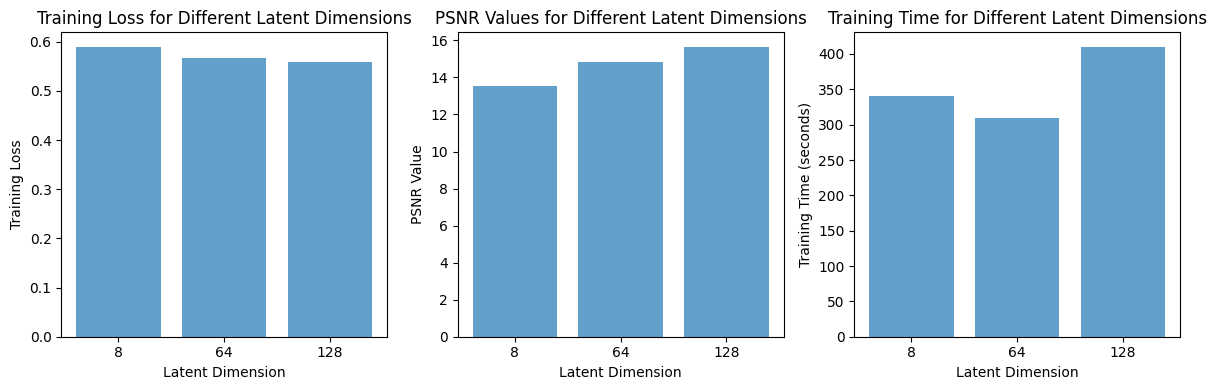

In [21]:

X_axis = np.arange(len(latent_dimensions))
psnr_values = PSNR_list
train_losses = [train_history[i]['loss'][0] for i in range(len(train_history))]
train_times = train_time


# Training loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.bar(X_axis, train_losses, align='center', alpha=0.7)
plt.xticks(X_axis, latent_dimensions)
plt.xlabel('Latent Dimension')
plt.ylabel('Training Loss')
plt.title('Training Loss for Different Latent Dimensions')


# PSNR values
plt.subplot(1, 3, 2)
plt.bar(X_axis, psnr_values, align='center', alpha=0.7)
plt.xticks(X_axis, latent_dimensions)
plt.xlabel('Latent Dimension')
plt.ylabel('PSNR Value')
plt.title('PSNR Values for Different Latent Dimensions')


# Training time
plt.subplot(1, 3, 3)
plt.bar(X_axis, train_times, align='center', alpha=0.7)
plt.xticks(X_axis, latent_dimensions)
plt.xlabel('Latent Dimension')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Different Latent Dimensions')

plt.tight_layout()
plt.show()



## Task 1.3.4: Discuss:
1. **What is a latent representation in the context of machine learning, and how does it differ from the original data representation?**

Latent representation is transformed to a lower dimension of the original data. It captures the most important features when transforming. Original data is the untransformed data, which is then higher dimensional.

2. **In unsupervised learning, why do researchers and practitioners often prefer to work with latent representations instead of raw data?**

Latent representaion reduce the dimensionality, that can lead to removing noise and reveal hidden structures in the data, which will then be more useful for recogniztion of patterns and feature extraction in unsupervised learning tasks.

3. **What challenges and potential drawbacks are associated with using latent representations in machine learning?**

Choosing the right size, for the latent space can be difficult and latent features are less interpretable than raw data features. Also we can lose important information when transforming the data.

4. **Discuss the trade-offs between using a
higher-dimensional latent space and a lower-dimensional one in various applications?**

Higher dimensionality spaces can model complex data better but may lead to overfitting and require more computitional resources. Lower dimensions are more computionally efficient and reduce the overfittng but might miss imporant patterns in the data.



---



# Task 2: Building a Variational Autoencoder (VAE) network

- Variational Autoencoders, in contrast to the deterministic Autoencoders, learn a probabilistic distribution over the latent space. VAEs use regularization techniques, such as the Kullback-Leibler (KL) divergence, to encourage the learned latent space to be continuous and well-structured. The KL divergence term in the VAE loss function penalizes the model if the learned latent space deviates significantly from a prior distribution, usually a simple Gaussian distribution.

<div>
<img src="https://tikz.net/janosh/vae.png" width="400"/>
<div>

## Task 2.1 Create a deep convelutional encoder and deocoder
- Build a deep CNN encoder and an symmetric decoder. Keep track of your dimension. A tip is to make the network dynamical w.r.t. the input dimensions of the image.
- Feel free to alter the architecture of the network as you see fit (belowe is an exampel on how to design your encoder and decoder.)


```
def encoder(input_shape, hidden_dim, laten_dim, model_name):
    """
        Builds the encoder architecture.
        Input_shape: dimension of image [BxHxWxC] - i.e. [256,28,28,3]
        hidden_layers: number and dimension of layers [l1, l2, l3], where layer (i) > layer (i+1) - i.e. [512, 256, 128]
        latnet_dim: dimension of latent space int - i.e. 64
    """
    # INITIATE INPUT STRUCTURE
    input = keras.Input(shape=(input_shape[0],input_shape[0], input_shape[2]), name='Image dimension')
    x = input

    # CONVOLUTIONAL LAYERS
    for l in hidden_dim:
        x = tf.keras.layers.Conv2D(l, 3, activation="relu", strides=2, padding="same", name='Conv_dim%i'%(l))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)

    # FLATTEN
    x = tf.keras.layers.Flatten(name='Flatten_1d_vector')(x)

    # LATENT SPACE
    x = keras.layers.Dense(laten_dim, name='Latent_space')(x)
    
    # VARIATIONAL LAYER
    z_mu = keras.layers.Dense(laten_dim, name='Z_mean')(x)
    z_var = keras.layers.Dense(laten_dim, name='Z_variation')(x)

    return tf.keras.Model(input,[z_mu, z_var], name=model_name)
```





```
def decoder(output_channel, hidden_dim, laten_dim, model_name):
    """
        Builds the decoder architecture.
        Output_channel: channels of image [C] (int) - i.e. 3
        hidden_layers: number and dimension of layers [l1, l2, l3], where layer (i) > layer (i+1) (should be same
            as encoder for a symmetric network) - i.e. [512, 256, 128]
        latnet_dim: dimension of latent space int - i.e. 64 (must be same as from encoding)
    """
    # INPUT FROM LATENT SAMPLE SPACE
    laten_input = keras.Input(shape=(laten_dim), name='Latent input')

    x = keras.layers.Dense(img_h*img_w*2, activation='relu', name='Latent_dense')(laten_input)
    x = keras.layers.Reshape((int(img_h/8), int(img_w/8), hidden_dim[-1]), name='Convolution_dimension')(x)

    # DE-CONVELUTIONAL LAYERS
    for l in hidden_dim[::-1]:
        x = tf.keras.layers.Conv2DTranspose(l, 3, activation="relu", strides=2, padding="same", name='ConvTransose_dim%i'%(l))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)

    # OUTPUT: SAME AS ORIGNIAL INPUT DIMENSIONS. Sigmoid for pixel values 0-1
    output = tf.keras.layers.Conv2DTranspose(output_channel, 3, activation="sigmoid", padding="same", name='Conv_Output')(x)

    return tf.keras.Model(laten_input, output, name=model_name)
```



In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models


def encoder(input_shape, hidden_dims, latent_dim, model_name='encoder'):

    # INITIATE INPUT STRUCTURE
    inputs = tf.keras.Input(shape=input_shape, name='encoder_input')
    x = inputs


    # CONVOLUTIONAL LAYERS
    for h_dim in hidden_dims:
        x = layers.Conv2D(h_dim, kernel_size=3, strides=2, padding="same", activation="relu", name=f'Conv_dim{h_dim}')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)


    # FLATTEN
    x = layers.Flatten(name='Flatten_1d_vector')(x)


    # VARIATIONAL LAYERS
    z_mean = layers.Dense(latent_dim, name='Z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='Z_log_var')(x)

    return models.Model(inputs, [z_mean, z_log_var], name=model_name)


def decoder(input_shape, hidden_dims, latent_dim, model_name='decoder'):

    # INPUT FROM LATENT SPACE
    latent_inputs = tf.keras.Input(shape=(latent_dim,), name='decoder_input')


    # DETERMINE SIZE NEEDED FOR FIRST DENSE LAYER
    initial_dim_x = input_shape[0] // (2 ** len(hidden_dims))
    initial_dim_y = input_shape[1] // (2 ** len(hidden_dims))
    x = layers.Dense(initial_dim_x * initial_dim_y * hidden_dims[-1], activation='relu', name='Dense_for_reshape')(latent_inputs)
    x = layers.Reshape((initial_dim_x, initial_dim_y, hidden_dims[-1]), name='Reshape_to_3d')(x)


    # DE-CONVOLUTIONAL LAYERS
    for h_dim in hidden_dims[::-1]:

        x = layers.Conv2DTranspose(h_dim, kernel_size=3, strides=2, padding="same", activation="relu", name=f'ConvTransose_dim{h_dim}')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)


    # OUTPUT: SAME AS ORIGINAL INPUT DIMENSIONS
    outputs = layers.Conv2DTranspose(input_shape[2], kernel_size=3, activation="sigmoid", padding="same", name='Decoder_output')(x)

    return models.Model(latent_inputs, outputs, name=model_name)



input_shape = (64, 64, 3)
hidden_dims = [512, 256, 128]
latent_dim = 64


enc = encoder(input_shape, hidden_dims, latent_dim)
dec = decoder(input_shape, hidden_dims, latent_dim)



## Task 2.2 Create a sampling layer using the reparameterization trick*
- To be able to update the parameters of VAE using backpropagation, we need to consider that the sampling node inside is stochastic in nature. We can compute the gradients of the sampling node with respect to the learned mean and log-variance vector. This is achived by reparameterize our sampling layer.

<div>
<img src="https://i.stack.imgur.com/Djjr1.png" width="400"/>
<div>


In [23]:
# Definitation of a reprarametrization layer
class reparameterization_layer(tf.keras.layers.Layer):
    """
    Input: Mean Vector, Variance Vector (from the variational layers of the Encoder - see illustration above)
    Output: Z = μ + σ⊙ε     where ε ~ 𝒩(0,1) and σ = exp(z_var/2)
    """
    def call(self,z_inputs):
        z_mean, z_std = z_inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_std) * epsilon, z_mean, z_std


In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models



def encoder(input_shape, hidden_dims, latent_dim, model_name='encoder'):

    inputs = tf.keras.Input(shape=input_shape, name='encoder_input')
    x = inputs

    for h_dim in hidden_dims:
        x = layers.Conv2D(h_dim, kernel_size=3, strides=2, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

    x = layers.Flatten()(x)

    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = reparameterization_layer()([z_mean, z_log_var])

    model = models.Model(inputs, [z_mean, z_log_var, z], name=model_name)

    return model



def decoder(input_shape, hidden_dims, latent_dim, model_name='decoder'):

    latent_inputs = tf.keras.Input(shape=(latent_dim,), name='decoder_input')

    x = layers.Dense(hidden_dims[-1] * (input_shape[0] // 2**len(hidden_dims)) * (input_shape[1] // 2**len(hidden_dims)), activation='relu')(latent_inputs)
    x = layers.Reshape((input_shape[0] // 2**len(hidden_dims), input_shape[1] // 2**len(hidden_dims), hidden_dims[-1]))(x)

    for h_dim in hidden_dims[::-1]:
        x = layers.Conv2DTranspose(h_dim, kernel_size=3, strides=2, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

    outputs = layers.Conv2DTranspose(input_shape[2], kernel_size=3, activation="sigmoid", padding="same", name='decoder_output')(x)

    return models.Model(latent_inputs, outputs, name=model_name)


input_shape = (64, 64, 3)
hidden_dims = [512, 256, 128]
latent_dim = 256


enc = encoder(input_shape, hidden_dims, latent_dim)
dec = decoder(input_shape, hidden_dims, latent_dim)



## Task 2.3 Build a custom model including reconstruction loss and KL divergence
- Below we have defined a keras Model that takes **the previously defined encoder and decoder** as input and designe the training process.
- The training process tracks two losses:


> **Reconstruction Loss** = $||x - \bar x ||_2 = ||x - decoder(z) ||_2 = ||x - d(\mu_x + \sigma_x \epsilon)||_2$ where $\mu_x,\sigma_x = encoder(x), \epsilon \sim \mathcal{N}(0,I)$


> **Similarity Loss/KL Divergence** = $D_{KL}(\mathcal{N}(\mu_x, \sigma_x) || \mathcal{N}(0,I))$



In [30]:
class VAE(tf.keras.Model):
    """
    Input: encoder, decoder
    1. Track reconstruction loss, kl divergence, and total loss
    2. Update gradients
    Output: loss
    """
    def __init__(self, encoder: tf.keras.Model, decoder: tf.keras.Model):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.rec_loss_tracker = keras.metrics.Mean(name="rec_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.tot_loss_tracker = keras.metrics.Mean(name="total_loss")

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z[0])
        return reconstructed


    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as grad:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z[0])
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(y, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = grad.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.tot_loss_tracker.update_state(total_loss)
        self.rec_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)


        return {
            "loss": self.tot_loss_tracker.result(),
            "reconstruction_loss": self.rec_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [26]:
# Build, compile and train a model
vae = VAE(encoder=enc, decoder=dec)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

history = vae.fit(train_ds,
                  epochs=5,
                  batch_size=64,
                  validation_data=validation_ds)


Epoch 1/5
624/624 [==============================] - 164s 242ms/step - loss: 2418.9565 - reconstruction_loss: 2381.0061 - kl_loss: 49.8239 - val_loss: 0.0000e+00 - val_rec_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/5
624/624 [==============================] - 133s 213ms/step - loss: 2221.2461 - reconstruction_loss: 2174.2556 - kl_loss: 58.1455 - val_loss: 0.0000e+00 - val_rec_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/5
624/624 [==============================] - 148s 237ms/step - loss: 2185.5789 - reconstruction_loss: 2136.9301 - kl_loss: 58.1335 - val_loss: 0.0000e+00 - val_rec_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/5
624/624 [==============================] - 132s 211ms/step - loss: 2166.6465 - reconstruction_loss: 2110.6844 - kl_loss: 59.4966 - val_loss: 0.0000e+00 - val_rec_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/5
624/624 [=====



---



# Task 3: Generate data
- Due to the probabilistic nature of VAEs, they can generate new data points by sampling from the learned latent space. By sampling from the latent distribution, the VAE can produce new data points that are similar to the training data but not identical to any specific input in the dataset.


## Task 3.1 Reconstruct sample by sampling the latent space
- Encode and decode a set of images



```
data_subset = np.stack(list(test_ds.take(1))).squeeze(0)[0]
reconstructed_image = Decode(Encode(data_subset)[0])
```



In [31]:
# Reconstruction of sample by sampling the latent space
data_subset = np.stack(list(validation_ds.take(1))).squeeze(0)[0]
reconstruced_image = vae.decoder(vae.encoder(data_subset)[0])

## Task 3.2 Generate new sample from a normal (Gaussian) distribution
- Decode an image from a random sample distribution (of same dimensions!)



```
z_distribution = np.random.normal(loc=tf.reduce_mean(z), scale=tf.square(tf.reduce_mean(z_var)), size=(1,128))
generated_image = Decode(z_distribution)
```



1/1 [==============================] - 0s 399ms/step


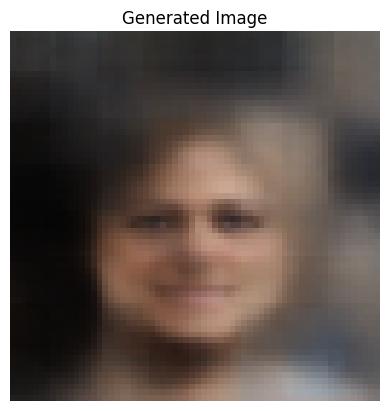

In [33]:
# Sample from a standard normal distribution
z_sample = np.random.normal(size=(1, latent_dim))

# Generate the image using the decoder
generated_image = vae.decoder.predict(z_sample)

# Assuming the generated image is in the right format and scale
plt.imshow(generated_image[0, :, :, :])
plt.title("Generated Image")
plt.axis('off')
plt.show()


## Task 3.3 Modify sample generation with desired attributes
- VAE learns a probability distribution of possible latent representations. By conditioning the space on desired attributes we can compare output from the two latent probability spaces (with and without the desired attribute.)
- Celeb A dataset comes with a set of hand annotated features for each image
- By building a latent space conditioned on a selected feature, the desired attribute should be prominent




In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/1z4OVK9yWa-4Q-Rjsok7ET6gJGiXYKi_K/preview" width="640" height="480" allow="autoplay"></iframe>

By adding the following to your **preprocessing function**, we can use the desired attributes as label to train a model with spesific properties.
```
if mode == 'attributes':
    img = example['image']
    attri = example['attributes']
    if attri[att]:
        label = 1
    else:
        label = 0
    img = tf.image.resize(img, size=size)/255.0
    return img, label
```

In [34]:
BATCH_SIZE = 32
img_w, img_h = 64,64

In [55]:
# New, extended preprocess function
def preprocess(example, att = 'Smiling', size=(img_w, img_h), mode='attributes'):
    image = example['image']
    if mode == 'train':
        image_resized = tf.image.resize(image, size=size)
        return image_resized / 255.0, image_resized / 255.0

    elif mode == 'attributes':
      img = example['image']
      attri = example['attributes']
      if attri[att]:
        label = 1
      else:
        label = 0
      img = tf.image.resize(img, size=size) / 255.0
      return img, label



In [56]:
train_att = celeba_train.map(lambda x: preprocess(x))
train_att = train_att.batch(BATCH_SIZE)
train_att = train_att.take(20)

Having defined the images with and without desired attribute, can can seperate them into two subset for training.

In [65]:
# Sorting relevant images
img_with = []
img_without = []
for images, labels in train_att:
    for i in range(BATCH_SIZE):
      if tf.reduce_any(tf.equal(labels[i], 1)):
         img_with.append(images[i])
      else:
         img_without.append(images[i])
img_with, img_without = np.array(img_with), np.array(img_without)

In [58]:
# Designing the latent space with desired attributes
_, z_mean_with, _ = vae.encoder(img_with)
attribute_vector = tf.reduce_mean(z_mean_with, axis=0, keepdims=True)

# Ensure attribute_vector has the shape (1, 256)
print("Shape of attribute_vector:", attribute_vector.shape)


Shape of attribute_vector: (1, 256)


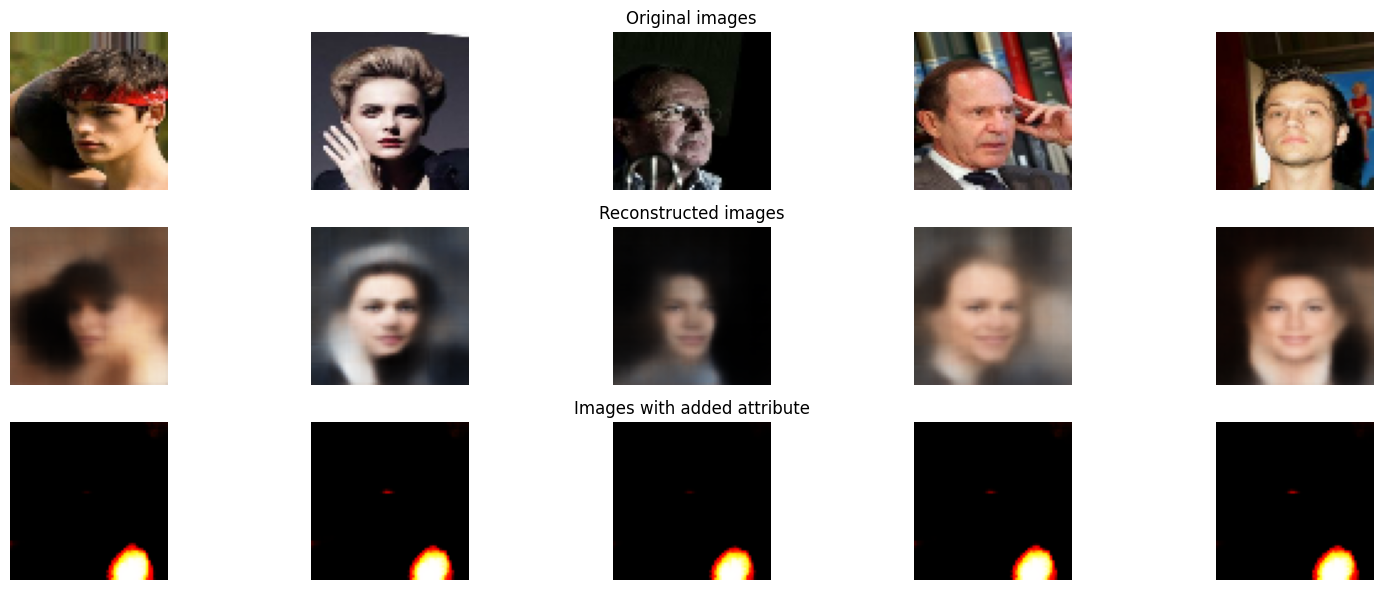

In [67]:
# Parameters
n_examples = 5
beta = 20


og_enc = vae.encoder(img_without)[0]
att_enc = og_enc + beta * attribute_vector



f, axs = plt.subplots(3, n_examples, figsize=(16, 6))

# Set titles
axs[0, n_examples // 2].set_title("Original images")
axs[1, n_examples // 2].set_title("Reconstructed images")
axs[2, n_examples // 2].set_title("Images with added attribute")

for j in range(n_examples):

    # Original image without attribute
    axs[0, j].imshow(img_without[j])

    # Reconstruction orignal latent space
    axs[1, j].imshow(vae.decoder(og_enc)[j])

    # Reconstructed conditioned latent space
    axs[2, j].imshow(vae.decoder(att_enc)[j])

    for ax in axs[:, j]:
       ax.axis('off')

plt.tight_layout();


## Task 3.4 Interpolation between points in the latent space

Interpolating the latent space of a generative machine learning model involves smoothly transitioning between different points in the latent space to generate new samples.

For example, in a model trained on images of faces, interpolating in the latent space would involve finding a path between two latent vectors corresponding to two different faces. As we traverse this path, the model generates images that morph gradually from one face to the other. This process allows us to create novel samples that possess characteristics of both original data points.

Overall, latent space interpolation provides a powerful tool for generating diverse and realistic data samples, enabling the model to create entirely new outputs that blend characteristics of the training data.

In [ ]:
%%html
<iframe src="https://drive.google.com/file/d/18qEB5YoxNpDqYyHgGXo0QZpx-VHNjWEb/preview" width="640" height="480" allow="autoplay"></iframe>

Run the following code

In [81]:
# Uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=5):
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)

In [82]:
def create_interpolated_samples():
    num_steps = 8
    step_size = 1.0 / num_steps

    # Initialize sample_a and sample_b
    sample_a, sample_b = None, None

    # Retrieve data that correspond to the class indices
    for img_batch, label_batch in train_att:
        img_batch_np = img_batch.numpy()
        label_batch_np = label_batch.numpy()
        for i, label in enumerate(label_batch_np):
            if sample_a is None and label == 1:
                sample_a = img_batch_np[i]
            if sample_b is None and label == 0:
                sample_b = img_batch_np[i]
            if sample_a is not None and sample_b is not None:
                break

        if sample_a is not None and sample_b is not None:
            break

    # Check if both samples were found
    if sample_a is None or sample_b is None:
        raise ValueError("Could not find required samples")

    # Process samples
    sample_a = tf.reshape(sample_a, [1, img_h, img_w, 3])
    sample_b = tf.reshape(sample_b, [1, img_h, img_w, 3])

    # Encode both images to get latent representations
    z_a, z_b = vae.encoder(sample_a)[0].numpy(), vae.encoder(sample_b)[0].numpy()

    # Interpolate in latent space
    interpolated_zs = interpolate_points(z_a, z_b, n_steps=num_steps)

    # Decode interpolated points
    out_imgs = [vae.decoder.predict(z.reshape(1, -1)) for z in interpolated_zs]

    return out_imgs


1/1 [==============================] - 0s 16ms/step


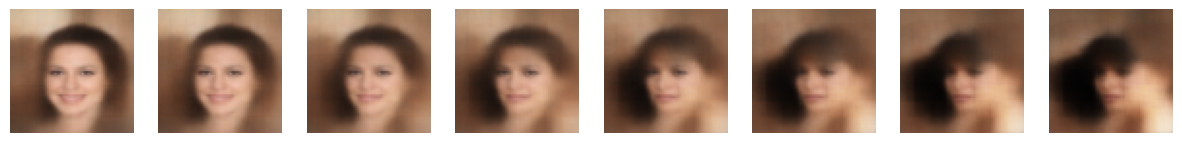

In [83]:
interpol_img = create_interpolated_samples()
fig, ax = plt.subplots(1, len(interpol_img), figsize=(15, 15))
for i, img in enumerate(interpol_img):
    ax[i].imshow(img[0, :, :, :])
    ax[i].axis('off')
plt.show()



---

